In [4]:
import argparse
import json
import multiprocessing
import os
import pickle
import platform
import threading
import time
from collections import Counter, defaultdict
from concurrent.futures import ProcessPoolExecutor, as_completed
from datetime import datetime
from typing import Any, Dict, List, Tuple
from warnings import warn

from multiprocessing import Value

from concurrent.futures import ThreadPoolExecutor

from tqdm import tqdm

import numpy as np

from evalplus.data.utils import CACHE_DIR

from evalplus.data import (
    get_human_eval_plus,
    get_human_eval_plus_hash,
    get_mbpp_plus,
    get_mbpp_plus_hash,
    load_solutions,
)

from evalplus.eval.utils import (
    create_tempdir,
    reliability_guard,
    swallow_io,
    time_limit,
)

from evalplus.eval._special_oracle import (
    MBPP_OUTPUT_NOT_NONE_TASKS,
    MBPP_OUTPUT_SET_EQ_TASKS,
    _poly,
)

from evalplus.gen.util import trusted_exec

def is_floats(x) -> bool:
    # check if it is float; List[float]; Tuple[float]
    if isinstance(x, float):
        return True
    if isinstance(x, (list, tuple)):
        return all(isinstance(i, float) for i in x)
    if isinstance(x, np.ndarray):
        return x.dtype == np.float64 or x.dtype == np.float32
    return False

import resource
import signal

def time_limit_exceeded(signum, frame):
    raise TimeoutError("Time limit exceeded")

def set_time_limit(seconds):
    signal.signal(signal.SIGALRM, time_limit_exceeded)
    signal.alarm(seconds)

def set_memory_limit(maximum_memory_bytes):
    import resource

    resource.setrlimit(
        resource.RLIMIT_AS, (maximum_memory_bytes, maximum_memory_bytes)
    )
    resource.setrlimit(
        resource.RLIMIT_DATA, (maximum_memory_bytes, maximum_memory_bytes)
    )
    if not platform.uname().system == "Darwin":
        resource.setrlimit(
            resource.RLIMIT_STACK, (maximum_memory_bytes, maximum_memory_bytes)
        )

def wrapped_ut_exact_match(
    hyp_ut, 
    ref_ut, 
    entry_point, 
    dataset, 
    inp=None, 
    atol=0, 
    time_bound = False,
    time_limit=1, 
    memory_bound = True,
    memory_limit=40*1024*1024, 
    ):
    final_result = Value('d', 0)
    with create_tempdir():
        # These system calls are needed when cleaning up tempdir.
        import os
        import shutil

        rmtree = shutil.rmtree
        rmdir = os.rmdir
        chdir = os.chdir
        if time_bound:
            set_time_limit(time_limit)
        try:
            if memory_bound:
                reliability_guard(maximum_memory_bytes=memory_limit)
            if time_bound:
                set_time_limit(time_limit)
            final_result = ut_exact_match(hyp_ut, ref_ut, entry_point, dataset, inp, atol, time_limit, memory_limit, memory_bound)
        except MemoryError:
            final_result = 0.0
        except TimeoutError:
            final_result = 0.0
    if time_bound:
        signal.alarm(0)
    shutil.rmtree = rmtree
    os.rmdir = rmdir
    os.chdir = chdir
    return final_result.value

def ut_exact_match(
    hyp_ut, 
    ref_ut, 
    entry_point, 
    dataset, 
    inp=None, 
    atol=0, # need to change this later
    time_limit=1, # seconds
    memory_limit=4*1024*1024*1024, # 4GB
    ):
    
    #try:
        #set_time_limit(time_limit)
        #set_memory_limit(memory_limit)

    exact_match = hyp_ut == ref_ut

    # ================================================ #
    # ============== special oracles ================= #
    if dataset == "mbpp":
        if "are_equivalent" == entry_point:  # Mbpp/164 special oracle
            exact_match = exact_match or True
        elif "sum_div" == entry_point:  # Mbpp/295 special oracle
            exact_match = exact_match or hyp_ut == 0 or ref_ut == 0
        elif entry_point in MBPP_OUTPUT_SET_EQ_TASKS:
            exact_match = set(hyp_ut) == set(ref_ut)
        elif entry_point in MBPP_OUTPUT_NOT_NONE_TASKS:
            # exp is True  if not None
            #        False if None
            if isinstance(hyp_ut, bool):
                hyp_ut = hyp_ut is not None
            if isinstance(ref_ut, bool):
                ref_ut = ref_ut is not None
            exact_match = hyp_ut == ref_ut

    if dataset == "humaneval":
        if "find_zero" == entry_point:
            hyp_ut = _poly(*inp, hyp_ut) <= atol
            ref_ut = _poly(*inp, ref_ut) <= atol
            exact_match = hyp_ut == ref_ut
    # ============== special oracles ================= #
    # ================================================ #

    if atol == 0 and (is_floats(ref_ut) or is_floats(hyp_ut)):
        atol = 1e-6  # enforce atol for float comparison
    if not exact_match and atol != 0:
        # explicitly set rtol=1e-07
        # to match `np.testing.assert_allclose`'s default values
        exact_match =  np.allclose(hyp_ut, ref_ut, rtol=1e-07, atol=atol)
    
    return int(exact_match)

def get_groundtruth(problems, hashcode, tasks_only_output_not_none):
    cache_file = os.path.join(CACHE_DIR, f"{hashcode}.pkl")
    if os.path.exists(cache_file):
        #print(f"Load from ground-truth from {cache_file}")
        with open(cache_file, "rb") as f:
            return pickle.load(f)

    os.makedirs(CACHE_DIR, exist_ok=True)
    #print("Computing expected output...")
    tbegin = time.time()
    expected_output = {}
    for task_id, problem in problems.items():
        oracle = {}
        oracle["base"], oracle["base_time"] = trusted_exec(
            problem["prompt"] + problem["canonical_solution"],
            problem["base_input"],
            problem["entry_point"],
            record_time=True,
            output_not_none=problem["entry_point"] in tasks_only_output_not_none,
        )

        oracle["plus"], oracle["plus_time"] = trusted_exec(
            problem["prompt"] + problem["canonical_solution"],
            problem["plus_input"],
            problem["entry_point"],
            record_time=True,
            output_not_none=problem["entry_point"] in tasks_only_output_not_none,
        )
        expected_output[task_id] = oracle
    #print(f"Expected outputs computed in {time.time() - tbegin:.2f}s")

    with open(cache_file, "wb") as f:
        pickle.dump(expected_output, f)

    return expected_output

In [5]:
def mbr_exec(hyp_uts, ref_uts, entry_point, dataset, n_uts, inps=None, granular=False):
    n_matches = 0
    for i in range(n_uts):
        # skip if either hyp_ut or ref_ut is not in the list
        if i not in hyp_uts or i not in ref_uts:
            continue
        # if there's an error, we return 0
        if type(hyp_uts[i]) == str and hyp_uts[i].startswith("failed:"):
            return 0 
        if type(ref_uts[i]) == str and ref_uts[i].startswith("failed:"):
            return 0
        # we start counting the number of matches
        try:
            n_matches += ut_exact_match(
                hyp_uts[i], 
                ref_uts[i], 
                entry_point, 
                dataset, 
                inp=inps[i] if inps else None
                )
        except:
            n_matches += 0
        
    if granular:
        try:
            return n_matches/ n_uts
        except:
            return 0
    else:
        return int(n_matches == n_uts)

In [22]:
work_dir = "/mnt/scratch-artemis/haausing/code_reranking/evalplus_outputs"
dataset = "mbpp"
gen_dir = "code-llama-13b-instruct_temp_1.6"
#debug_gen_dir = gen_dir + "_debug1_not_change_positive"
#debug_gen_dir = gen_dir + "_debug1_sd-ut"
#debug_3times_gen_dir = gen_dir + "_debug1_sd-ut"
#_debug1_not_change_positive
# load exec_outputs

# load problems
if dataset == "mbpp":
    problems = get_mbpp_plus()
    dataset_hash = get_mbpp_plus_hash()
    expected_output = get_groundtruth(
        problems,
        dataset_hash,
        MBPP_OUTPUT_NOT_NONE_TASKS,
    )
elif dataset == "humaneval":
    problems = get_human_eval_plus()
    dataset_hash = get_human_eval_plus_hash()
    expected_output = get_groundtruth(
        problems,
        dataset_hash,
        []
    )
else:
    raise ValueError("Invalid dataset")

with open(f"{work_dir}/{dataset}/{gen_dir}/exec_outputs_v2.pkl", "rb") as f:
    exec_outputs = pickle.load(f)
print("exec_outputs loaded")

# load exec_outputs
#with open(f"{work_dir}/{dataset}/{debug_gen_dir}/exec_outputs_v2.pkl", "rb") as f:
#    exec_outputs_debug = pickle.load(f)
#print("exec_outputs_debug loaded")

# load eval_results
with open(f"{work_dir}/{dataset}/{gen_dir}/eval_results.json", "r") as f:
    eval_results = json.load(f)
for task_id in eval_results["eval"]:
    eval_results["eval"][task_id] = sorted(eval_results["eval"][task_id], key=lambda x: int(x["solution_id"]))
    
#pop out ["Mbpp/6", "Mbpp/7", "Mbpp/8", "Mbpp/9"]
if dataset == "mbpp":
    for task_id in ["Mbpp/6", "Mbpp/7", "Mbpp/8", "Mbpp/9"]:
        eval_results["eval"].pop(task_id)
print("eval_results loaded")

# load eval_results
#with open(f"{work_dir}/{dataset}/{debug_gen_dir}/eval_results.json", "r") as f:
#    ape_eval_results = json.load(f)
#for task_id in ape_eval_results["eval"]:
#    ape_eval_results["eval"][task_id] = sorted(ape_eval_results["eval"][task_id], key=lambda x: int(x["solution_id"]))
#print("ape_eval_results loaded")

# load eval_results
#with open(f"{work_dir}/{dataset}/{debug_3times_gen_dir}/eval_results.json", "r") as f:
#    ape_3times_eval_results = json.load(f)
#for task_id in ape_3times_eval_results["eval"]:
#    ape_3times_eval_results["eval"][task_id] = sorted(ape_3times_eval_results["eval"][task_id], key=lambda x: int(x["solution_id"]))

exec_outputs loaded
eval_results loaded


In [23]:
if dataset == "mbpp":
    for task_id in errors:
        if task_id in ["Mbpp/6", "Mbpp/7", "Mbpp/8", "Mbpp/9"]:
            continue
        for i in range(len(errors[task_id])):
            status = errors[task_id][i]["base"]["status"] == "pass"
            if status:
                try:
                    assert eval_results["eval"][task_id][i]["base_details"][0] == 1
                except:
                    print("task_id: {}, i: {}".format(task_id, i))
                    print(eval_results["eval"][task_id][i]["base_status"])
            else:
                if len(eval_results["eval"][task_id][i]["base_details"]) > 0:
                    if eval_results["eval"][task_id][i]["base_details"][0] == 1:
                        print("task_id: {}, i: {}".format(task_id, i))
                        print(eval_results["eval"][task_id][i]["base_status"])


NameError: name 'errors' is not defined

In [ ]:
if dataset == "humaneval":
    with open(f"{work_dir}/{dataset}/{gen_dir}/errors.pkl", "rb") as f:
        errors = pickle.load(f)

In [ ]:
from concurrent.futures import ThreadPoolExecutor

def process_task(task_id, eval_results_dict, exec_outputs_dict, max_hyps = 200, start_id = 0, num_plus_test_cases=3, granular=False, filter = True):
    test_all_plus_cases = True
    assert start_id >= 0 and start_id + max_hyps <= 200
    n_expected_outputs_base = len(expected_output[task_id]["base"])
    n_expected_outputs_plus = len(expected_output[task_id]["plus"])
    if num_plus_test_cases < n_expected_outputs_plus:
        test_all_plus_cases = False
    task_utility_base = []
    task_utility_plus = []
    
    for hyp_id, hyp in enumerate(eval_results_dict["eval"][task_id]):
        if hyp_id >= max_hyps + start_id or hyp_id < start_id:
            continue
        hyp_base_outputs = exec_outputs_dict[task_id][hyp_id]["base"]
        hyp_plus_outputs = exec_outputs_dict[task_id][hyp_id]["plus"]
        if not test_all_plus_cases:
            hyp_plus_outputs = {i: hyp_plus_outputs[i] for i in range(num_plus_test_cases) if i < min(num_plus_test_cases, len(hyp_plus_outputs))}
        hyp_utility_base = []
        hyp_utility_plus = []
        
        for ref_id, ref in enumerate(eval_results_dict["eval"][task_id]):
            if ref_id >= max_hyps + start_id or ref_id < start_id:
                continue
            if ref["base_status"] == ref["plus_status"] == hyp["base_status"] == hyp["plus_status"] == "pass":
                hyp_utility_base.append(1)
                hyp_utility_plus.append(1)
                continue
            if filter:
                ### add the filtering baseline
                if dataset in "humaneval":
                    if errors[task_id][hyp_id]["base"]["status"] != "pass":
                        hyp_utility_base.append(0)
                        hyp_utility_plus.append(0)
                        continue
                elif dataset == "mbpp":
                    if len(hyp["base_details"]) == 0 or hyp["base_details"][0] == 0:
                        hyp_utility_base.append(0)
                        hyp_utility_plus.append(0)
                        continue
                ### end of filtering baseline
            ref_base_outputs = exec_outputs_dict[task_id][ref_id]["base"]
            ref_plus_outputs = exec_outputs_dict[task_id][ref_id]["plus"]
            if not test_all_plus_cases:
                ref_plus_outputs = {i: ref_plus_outputs[i] for i in range(num_plus_test_cases) if i < min(num_plus_test_cases, len(ref_plus_outputs))}
            
            util_score_base = mbr_exec(hyp_base_outputs, ref_base_outputs, problems[task_id]["entry_point"], "mbpp", n_expected_outputs_base, granular=granular)
            util_score_plus = mbr_exec(hyp_plus_outputs, ref_plus_outputs, problems[task_id]["entry_point"], "mbpp", n_expected_outputs_plus, granular=granular)
            hyp_utility_base.append(util_score_base)
            if granular:
                hyp_utility_plus.append((util_score_plus*n_expected_outputs_plus+util_score_base*n_expected_outputs_base)/(n_expected_outputs_plus+n_expected_outputs_base))
            else:
                hyp_utility_plus.append(int(util_score_plus==util_score_base==1))
            #hyp_utility_plus.append(mbr_exec(hyp_plus_outputs, ref_plus_outputs, problems[task_id]["entry_point"], "mbpp", n_expected_outputs_plus))
        #hyp_utility_plus.extend(hyp_utility_base)
        task_utility_base.append(np.mean(hyp_utility_base))
        task_utility_plus.append(np.mean(hyp_utility_plus))
    
    # get argmax
    argmax_base = np.argmax(task_utility_base) + start_id
    argmax_plus = np.argmax(task_utility_plus) + start_id
    assert argmax_base == int(eval_results_dict["eval"][task_id][argmax_base]["solution_id"])
    assert argmax_plus == int(eval_results_dict["eval"][task_id][argmax_plus]["solution_id"])
    base_status = eval_results_dict["eval"][task_id][argmax_base]["base_status"]
    plus_status = eval_results_dict["eval"][task_id][argmax_plus]["plus_status"]
    if not test_all_plus_cases:
        argmax_plus_solution = eval_results_dict["eval"][task_id][argmax_plus]
        if len(argmax_plus_solution["plus_details"]) < min(num_plus_test_cases, len(expected_output[task_id]["plus"])):
            plus_status = "fail"
        else:
            if all(argmax_plus_solution["plus_details"][:num_plus_test_cases]):
                plus_status = "pass"
            else:
                plus_status = "fail"
    return (int(base_status == "pass"), int(base_status == plus_status == "pass"), argmax_base, argmax_plus)

In [ ]:
def get_results(eval_results, exec_outputs, max_hyps=200, start_id=0, num_plus_test_cases=300, granular=False, filter=True, workers=20):
    for task_id in eval_results["eval"]:
        eval_results["eval"][task_id] = sorted(eval_results["eval"][task_id], key=lambda x: int(x["solution_id"]))
        
    base_results = {}
    plus_results = {}
    argmax_bases = {}
    argmax_pluss = {}
    
    def process_single_task(task_id):
        base_result, plus_result, argmax_base, argmax_plus = process_task(task_id, 
                                                                          eval_results, 
                                                                          exec_outputs, 
                                                                          max_hyps=max_hyps, 
                                                                          start_id=start_id, 
                                                                          num_plus_test_cases=num_plus_test_cases, 
                                                                          granular=granular, 
                                                                          filter=filter)
        base_results[task_id] = base_result
        plus_results[task_id] = plus_result
        argmax_bases[task_id] = argmax_base
        argmax_pluss[task_id] = argmax_plus

    with ThreadPoolExecutor(max_workers=workers) as executor:
        list(tqdm(executor.map(process_single_task, eval_results["eval"]), total=len(eval_results["eval"])))
    
    return base_results, plus_results

In [ ]:
num_plus_test_cases = 300
max_hyps = 50
granular = False
filter = True
workers = 1
base_score = []
plus_score = []
for start_id in range(0, 200, max_hyps):
    #the thing that dont pass is between 120 and 125s
    #if start_id == 120:
    #    continue
    base_results, plus_results = get_results(eval_results, 
                                             exec_outputs, 
                                             max_hyps=max_hyps, 
                                             start_id=start_id, 
                                             num_plus_test_cases=num_plus_test_cases,
                                             granular=granular,
                                             filter=filter, 
                                             workers=workers)

    base_score.append(sum(base_results.values())/len(base_results))
    plus_score.append(sum(plus_results.values())/len(plus_results))

  0%|          | 0/395 [00:00<?, ?it/s]

100%|██████████| 395/395 [00:04<00:00, 91.28it/s] 


In [21]:
round_digits = 10
print("filter: {}".format(filter))
print("dataset: {}".format(dataset))
print("model: {}".format(gen_dir))
print("number of hypotheses: {}".format(max_hyps))
print("MBR base     ", np.round(sum(base_score)/len(base_score) * 100, round_digits), "%")
print("-"*100)
print("MBR plus     ", np.round(sum(plus_score)/len(plus_score) * 100, round_digits), "%")

filter: True
dataset: mbpp
model: deepseek-coder-6.7b-instruct_temp_0.8
number of hypotheses: 50
MBR base      87.3417721519 %
----------------------------------------------------------------------------------------------------
MBR plus      80.5063291139 %


In [ ]:
# filter: False
# dataset: humaneval
# model: deepseek-coder-6.7b-instruct_temp_0.8
# number of hypotheses: 50
# MBR base      87.0426829268 %
# ----------------------------------------------------------------------------------------------------
# MBR plus      85.8231707317 %

# filter: True
# dataset: humaneval
# model: deepseek-coder-6.7b-instruct_temp_0.8
# number of hypotheses: 50
# MBR base      90.7012195122 %
# ----------------------------------------------------------------------------------------------------
# MBR plus      89.7865853659 %

# filter: False
# dataset: humaneval
# model: code-llama-13b-instruct_temp_0.8
# number of hypotheses: 50
# MBR base      58.993902439 %
# ----------------------------------------------------------------------------------------------------
# MBR plus      54.4207317073 %

# filter: True
# dataset: humaneval
# model: code-llama-13b-instruct_temp_0.8
# number of hypotheses: 50
# MBR base      76.5243902439 %
# ----------------------------------------------------------------------------------------------------
# MBR plus      69.2073170732 %

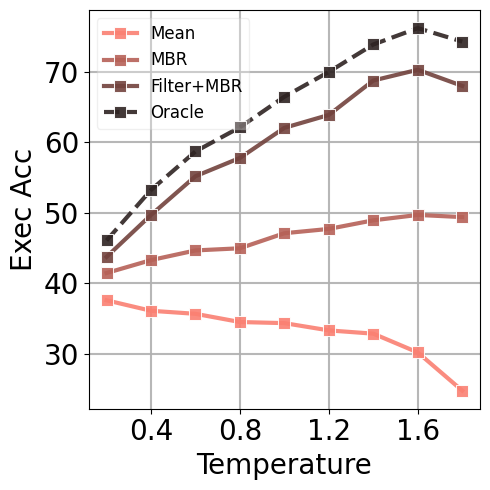

In [2]:
#### humaneval dataset ####

### without filtering

# MBR base scores for different temperatures and number of hypotheses
mbr_base_5 = [43.9634146341, 44.6341463415, 45.5640243902, 45.5792682927, 46.112804878, 
              46.4786585366, 46.5396341463, 45.9146341463, 43.2012195122]
mbr_base_10 = [44.5426829268, 45.8841463415, 47.1341463415, 46.7987804878, 47.8353658537, 
               49.1158536585, 48.9024390244, 49.3902439024, 47.7743902439]
mbr_base_20 = [44.8780487805, 46.5243902439, 48.3536585366, 47.987804878, 48.8414634146, 
               49.6341463415, 50.487804878, 50.6097560976, 50.6775067751]
mbr_base_25 = [45.3506097561, 46.493902439, 48.3993902439, 48.1707317073, 49.0853658537, 
               50.4573170732, 51.1432926829, 50.9908536585, 50.7839721254]
mbr_base_50 = [45.2743902439, 46.9512195122, 48.0182926829, 48.3231707317, 49.0853658537, 
               50.3048780488, 51.2195121951, 52.1341463415, 51.4227642276]

# MBR plus scores for different temperatures and number of hypotheses
mbr_plus_5 = [39.862804878, 40.4420731707, 41.5243902439, 41.493902439, 42.5, 
              42.6676829268, 42.7743902439, 42.3170731707, 39.3140243902]
mbr_plus_10 = [40.4268292683, 41.8292682927, 43.1707317073, 42.9573170732, 44.7865853659, 
               45.7317073171, 45.8231707317, 46.4634146341, 44.2987804878]
mbr_plus_20 = [40.8536585366, 42.6829268293, 44.756097561, 44.5731707317, 46.3414634146, 
               46.8292682927, 47.9268292683, 48.4146341463, 47.6287262873]
mbr_plus_25 = [41.3109756098, 42.6829268293, 44.8170731707, 44.9695121951, 46.7225609756, 
               47.5609756098, 48.3993902439, 48.7804878049, 48.2578397213]
mbr_plus_50 = [41.4634146341, 43.2926829268, 44.6646341463, 44.9695121951, 47.1036585366, 
               47.7134146341, 48.9329268293, 49.6951219512, 49.3902439024]

### with filtering

# MBR base scores with filtering for different temperatures and number of hypotheses
filter_mbr_base_5 = [46.1585365854, 48.5365853659, 51.3719512195, 52.3780487805, 54.0396341463, 
                     54.9237804878, 56.3109756098, 55.3353658537, 51.6006097561]
filter_mbr_base_10 = [47.1036585366, 50.9146341463, 54.9085365854, 56.4329268293, 58.9634146341, 
                      60.6707317073, 62.1951219512, 62.2865853659, 60.1524390244]
filter_mbr_base_20 = [47.987804878, 52.6829268293, 57.9268292683, 60.1829268293, 63.2926829268, 
                      64.5731707317, 67.6219512195, 68.4146341463, 66.2804878049]
filter_mbr_base_25 = [48.3231707317, 53.2012195122, 59.0701219512, 61.5091463415, 64.3292682927, 
                      66.1585365854, 68.368902439, 69.7408536585, 68.75]
filter_mbr_base_50 = [48.7804878049, 54.4207317073, 60.5182926829, 63.5670731707, 
                      66.7682926829, 69.0548780488, 73.1707317073, 74.5426829268, 72.256097561]

# MBR plus scores with filtering for different temperatures and number of hypotheses
filter_mbr_plus_5 = [41.5091463415, 43.7347560976, 46.6768292683, 47.2103658537, 49.0243902439, 
                     49.4207317073, 50.7317073171, 50.1676829268, 46.3719512195]
filter_mbr_plus_10 = [42.2865853659, 46.2804878049, 50.0609756098, 51.2804878049, 54.0853658537, 
                      55.4268292683, 56.9817073171, 57.1951219512, 54.756097561]
filter_mbr_plus_20 = [42.987804878, 48.1097560976, 53.1097560976, 55.0609756098, 58.2926829268, 
                      59.1463414634, 62.9268292683, 64.0243902439, 61.5243902439]
filter_mbr_plus_25 = [43.4451219512, 48.3993902439, 54.0396341463, 56.1737804878, 59.2987804878, 
                      60.7469512195, 63.7957317073, 65.0152439024, 64.4054878049]
filter_mbr_plus_50 = [43.75, 49.6951219512, 55.1829268293, 57.7743902439, 62.0426829268, 
                      63.8719512195, 68.75, 70.2743902439, 67.987804878]

### oracle

# Oracle base scores for different temperatures and number of hypotheses
oracle_base_5 = [0.46755329378874416, 0.5045713575895822, 0.5340735452627905, 0.5475827152581202, 0.5665269533346748, 
                 0.5785644847105087, 0.5959882110285796, 0.5864145888102014, 0.5425420285290881]
oracle_base_10 = [0.4804237646256191, 0.5363459247950413, 0.5783816069824679, 0.5995642686078495, 0.6262331523004543, 
                  0.6465815884892683, 0.6728107844265674, 0.6721472276082698, 0.6382356564590191]
oracle_base_20 = [0.4952714469714611, 0.5641549887693638, 0.6149008322311568, 0.6432405260372533, 0.6756837032137045, 
                  0.7047776189341985, 0.7386244820492126, 0.7458570149045832, 0.7193538931659649]
oracle_base_25 = [0.5002995374086717, 0.5716961214657916, 0.6245708951466781, 0.6556954161677369, 0.6899608248900694, 
                  0.7220406975038142, 0.7580379801958218, 0.766968676070771, 0.7425873161176749]
oracle_base_50 = [0.5144202396048416, 0.5903064971844135, 0.6497015330357376, 0.6906412726886849, 0.7301752264226173, 
                  0.7709124448760063, 0.8127817316100191, 0.8238279449187789, 0.805951259339323]

# Oracle plus scores for different temperatures and number of hypotheses
oracle_plus_5 = [0.41782433001513636, 0.45138257544952953, 0.48060752700205955, 0.48953859377863573, 0.5114147624559613, 
                 0.5186913014399662, 0.534211047096635, 0.5281954757091621, 0.48745654829998614]
oracle_plus_10 = [0.42936122346930944, 0.48098321265491406, 0.5225457103296826, 0.5376657235915504, 0.5681985800497352, 
                  0.582310452979136, 0.6075461067623011, 0.612347957461032, 0.5787528301477058]
oracle_plus_20 = [0.44298002505048706, 0.507099130895116, 0.556409566779627, 0.5771649590434836, 0.6137772056551767, 
                  0.6348626577194612, 0.6685210335948948, 0.684540110168908, 0.6584248297512403]
oracle_plus_25 = [0.4476360396172848, 0.5142799611945306, 0.5651292523660775, 0.5883370468842906, 0.6267857364028063, 
                  0.6506959827528456, 0.6864367845177586, 0.7051600032015305, 0.6813566710626895]
oracle_plus_50 = [0.4607931744073077, 0.5323870903649771, 0.5869190965906116, 0.6212038015865897, 0.6645325967198031, 
                  0.6997027542640166, 0.7385633381311683, 0.761755427566514, 0.7427083934918366]

mean_base = [0.42054878048780486, 0.40707317073170735, 0.40307926829268304, 0.3911280487804878, 0.3873475609756097,
            0.3770731707317073, 0.3722865853658537, 0.3413109756097561, 0.2769207317073171]
mean_plus = [0.37594512195121954, 0.36109756097560974, 0.3567987804878049, 0.34515243902439025, 0.34359756097560973,
            0.3332926829268293, 0.32865853658536587, 0.3020426829268293, 0.24795731707317076]

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for each hypothesis count (example data, replace with actual values)
mbr_base_scores = {
    5: mbr_base_5,
    10: mbr_base_10,
    20: mbr_base_20,
    25: mbr_base_25,
    50: mbr_base_50
}
mbr_plus_scores = {
    5: mbr_plus_5,
    10: mbr_plus_10,
    20: mbr_plus_20,
    25: mbr_plus_25,
    50: mbr_plus_50
}

filtering_mbr_base_scores = {
    5: filter_mbr_base_5,
    10: filter_mbr_base_10,
    20: filter_mbr_base_20,
    25: filter_mbr_base_25,
    50: filter_mbr_base_50
}
filtering_mbr_plus_scores = {
    5: filter_mbr_plus_5,
    10: filter_mbr_plus_10,
    20: filter_mbr_plus_20,
    25: filter_mbr_plus_25,
    50: filter_mbr_plus_50
}

base_oracle = {
    5: oracle_base_5,
    10: oracle_base_10,
    20: oracle_base_20,
    25: oracle_base_25,
    50: oracle_base_50
}
plus_oracle = {
    5: oracle_plus_5,
    10: oracle_plus_10,
    20: oracle_plus_20,
    25: oracle_plus_25,
    50: oracle_plus_50
}

# Multiply all oracle scores by 100
base_oracle = {key: [x * 100 for x in value] for key, value in base_oracle.items()}
plus_oracle = {key: [x * 100 for x in value] for key, value in plus_oracle.items()}
mean_plus = [x * 100 for x in mean_plus]
mean_base = [x * 100 for x in mean_base]

# Setup for plotting
#fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 3 subplots
fig, ax = plt.subplots(figsize=(5, 5))  # Single subplot

# Hypotheses counts
hypotheses = [5, 10, 20, 25, 50]
temps = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
temps_oracle = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]

alpha = 0.9
line_width = 3
marker_size = 8
legend_added = False
#for i, ax in enumerate(axs):
#hyp = hypotheses[2*i]
hyp = hypotheses[-1]
palette = sns.color_palette("ch:start=.2,rot=-.3", 7)  # Define a palette with 3 colors
#sns.lineplot(x=temps, y=mbr_base_scores[hyp], label='MBR' if not legend_added else "", marker='o', linestyle='--', color=palette[2], alpha=alpha, linewidth=line_width, ax=ax)
#sns.lineplot(x=temps, y=filtering_mbr_base_scores[hyp], label='MBR-Filter' if not legend_added else "", linestyle='--', marker='o', color=palette[3], alpha=alpha, linewidth=line_width, ax=ax)
#sns.lineplot(x=temps_oracle, y=base_oracle[hyp], label='Pass@k' if not legend_added else "", marker='o', color=palette[4], alpha=alpha, linewidth=line_width, ax=ax)

palette_dashed = sns.color_palette("dark:salmon_r", 7)  # Define a palette with 2 colors for dashed lines
sns.lineplot(x=temps, y=mean_plus, label='Mean' if not legend_added else "", marker='s', markersize=marker_size,
             color=palette_dashed[0], alpha=alpha, linewidth=line_width, ax=ax)
sns.lineplot(x=temps, y=mbr_plus_scores[hyp], label='MBR' if not legend_added else "", marker='s', markersize=marker_size,
             color=palette_dashed[2], alpha=alpha, linewidth=line_width, ax=ax)
sns.lineplot(x=temps, y=filtering_mbr_plus_scores[hyp], label='Filter+MBR' if not legend_added else "", marker='s', markersize=marker_size,
             color=palette_dashed[4], alpha=alpha, linewidth=line_width, ax=ax)
sns.lineplot(x=temps_oracle, y=plus_oracle[hyp], label='Oracle' if not legend_added else "", linestyle='--', marker='s', markersize=marker_size,
             color=palette_dashed[6], alpha=alpha, linewidth=line_width, ax=ax)
#ax.set_title(f'{hyp} Candidates', fontsize=20)

#if i == 0:  # Only set axis labels for the first subplot
ax.set_ylabel('Exec Acc', fontsize=20)
#if i == 1:
ax.set_xlabel('Temperature', fontsize=20)
#ax.grid(True, linestyle='--', linewidth=0.5)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xticks([i for i in np.arange(0.4, 2.0, 0.4)])
#if i != 0:
ax.tick_params(axis='y', left=False, labelleft=False)

if not legend_added:
    ax.legend(fontsize=12, shadow=False, fancybox=True, loc='upper left', framealpha=0.3)
    legend_added = True

# Align y-axis among all subplots
#y_min = min(ax.get_ylim()[0] for ax in axs)
#y_max = max(ax.get_ylim()[1] for ax in axs)
y_min, y_max = ax.get_ylim()
#for ax in axs:
ax.set_ylim(y_min, y_max)
ax.tick_params(axis='y', left=True, labelleft=True)  # Ensure y-axis ticks are shown
plt.grid(True, linestyle='-', linewidth=1.5, alpha=alpha)

plt.tight_layout()
plt.savefig('../figs/humaneval_temp_all.jpg', dpi=300, bbox_inches='tight', pad_inches=0.01)
plt.show()

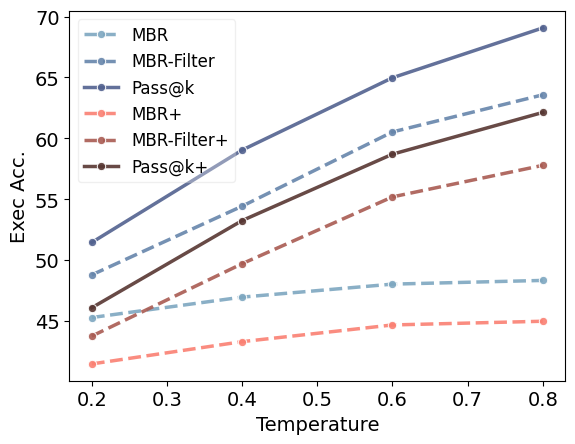

In [233]:
import seaborn as sns
from matplotlib import pyplot as plt

temps_oracle = [0.2, 0.4, 0.6, 0.8]
base_oracle = [0.5144202396048416, 0.5903064971844135, 0.6497015330357376, 0.6906412726886849]
plus_oracle = [0.4607931744073077, 0.5323870903649771, 0.5869190965906116, 0.6212038015865897]

temps = [0.2, 0.4, 0.6, 0.8]

mbr_base_scores = [45.2743902439, 46.9512195122, 48.0182926829, 48.3231707317]
mbr_plus_scores = [41.4634146341, 43.2926829268, 44.6646341463, 44.9695121951]

filtering_mbr_base_scores = [48.7804878049, 54.4207317073, 60.5182926829, 63.5670731707]
filtering_mbr_plus_scores = [43.75, 49.6951219512, 55.1829268293, 57.7743902439]

# for each number in the lists above, times 100
base_oracle = [x * 100 for x in base_oracle]
plus_oracle = [x * 100 for x in plus_oracle]

alpha = 0.9
line_width = 2.5
palette = sns.color_palette("ch:start=.2,rot=-.3", 7)  # Define a palette with 3 colors
sns.lineplot(x=temps, y=mbr_base_scores, label='MBR', marker='o', linestyle='--', color=palette[2], alpha=alpha, linewidth=line_width)
sns.lineplot(x=temps, y=filtering_mbr_base_scores, label='MBR-Filter', linestyle='--', marker='o', color=palette[3], alpha=alpha, linewidth=line_width)
sns.lineplot(x=temps_oracle, y=base_oracle, label='Pass@k', marker='o', color=palette[4], alpha=alpha, linewidth=line_width)

palette_dashed = sns.color_palette("dark:salmon_r", 6)  # Define a palette with 2 colors for dashed lines
sns.lineplot(x=temps, y=mbr_plus_scores, label='MBR+', marker='o', linestyle='--', color=palette_dashed[0], alpha=alpha, linewidth=line_width)
sns.lineplot(x=temps, y=filtering_mbr_plus_scores, label='MBR-Filter+', marker='o', linestyle='--', color=palette_dashed[2], alpha=alpha, linewidth=line_width)
sns.lineplot(x=temps_oracle, y=plus_oracle, label='Pass@k+', marker='o', color=palette_dashed[4], alpha=alpha, linewidth=line_width)

#plt.title('HumanEval', fontsize=30, alpha=alpha)
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Exec Acc.', fontsize=14)
plt.legend(
    fontsize=12,
    #title='methods', 
    #title_fontsize='16',
    shadow=False, 
    fancybox=True, 
    loc='upper left', 
    framealpha=0.3,
    #bbox_to_anchor=(1.05, 1) 
)
#plt.grid(True, linestyle='--', linewidth=0.5, alpha=alpha)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 
plt.savefig('../figs/humaneval_temp_0_8.jpg', dpi=100, bbox_inches='tight')
plt.show()

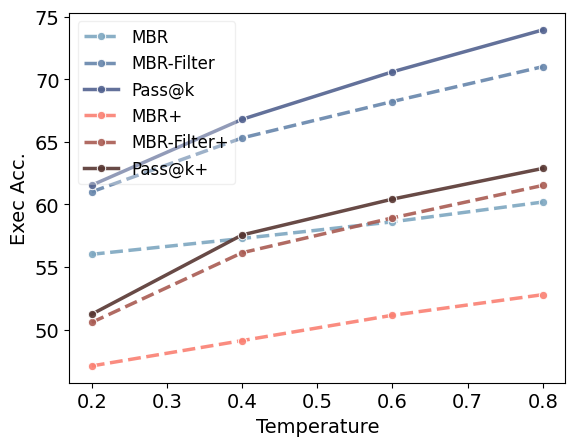

In [232]:
import seaborn as sns
from matplotlib import pyplot as plt

temps_oracle = [0.2, 0.4, 0.6, 0.8]
base_oracle = [0.6154194711728441, 0.6680436791860344, 0.7060274186242174, 0.7395197979175396]
plus_oracle = [0.5122389714499331, 0.5756011438762475, 0.604258647310824, 0.628783076797045]

temps = [0.2, 0.4, 0.6, 0.8]

mbr_base_scores = [56.0126582278, 57.2784810127, 58.6075949367, 60.1898734177]
mbr_plus_scores = [47.0886075949, 49.1139240506, 51.1392405063, 52.7848101266]

filtering_mbr_base_scores = [61.0126582278, 65.3164556962, 68.2278481013, 71.0126582278]
filtering_mbr_plus_scores = [50.5696202532, 56.1392405063, 58.9240506329, 61.5189873418]

# for each number in the lists above, times 100
base_oracle = [x * 100 for x in base_oracle]
plus_oracle = [x * 100 for x in plus_oracle]

alpha = 0.9
line_width = 2.5
palette = sns.color_palette("ch:start=.2,rot=-.3", 7)  # Define a palette with 3 colors
sns.lineplot(x=temps, y=mbr_base_scores, label='MBR', marker='o', linestyle='--', color=palette[2], alpha=alpha, linewidth=line_width)
sns.lineplot(x=temps, y=filtering_mbr_base_scores, label='MBR-Filter', linestyle='--', marker='o', color=palette[3], alpha=alpha, linewidth=line_width)
sns.lineplot(x=temps_oracle, y=base_oracle, label='Pass@k', marker='o', color=palette[4], alpha=alpha, linewidth=line_width)

palette_dashed = sns.color_palette("dark:salmon_r", 6)  # Define a palette with 2 colors for dashed lines
sns.lineplot(x=temps, y=mbr_plus_scores, label='MBR+', marker='o', linestyle='--', color=palette_dashed[0], alpha=alpha, linewidth=line_width)
sns.lineplot(x=temps, y=filtering_mbr_plus_scores, label='MBR-Filter+', marker='o', linestyle='--', color=palette_dashed[2], alpha=alpha, linewidth=line_width)
sns.lineplot(x=temps_oracle, y=plus_oracle, label='Pass@k+', marker='o', color=palette_dashed[4], alpha=alpha, linewidth=line_width)

#plt.title('MBPP', fontsize=30, alpha=alpha)
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Exec Acc.', fontsize=14)
plt.legend(
    fontsize=12,
    #title='methods', 
    #title_fontsize='16',
    shadow=False, 
    fancybox=True, 
    loc='upper left', 
    framealpha=0.3,
    #bbox_to_anchor=(1.05, 1) 
)
#plt.grid(True, linestyle='--', linewidth=0.5, alpha=alpha)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 
plt.savefig('../figs/mbpp_temp_0_8.jpg', dpi=100, bbox_inches='tight')
plt.show()

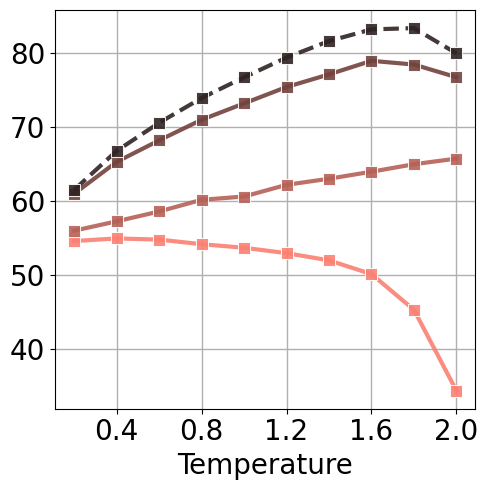

In [2]:
### mbpp
import seaborn as sns
from matplotlib import pyplot as plt

# Lists for MBR base scores without filtering for each number of hypotheses
mbr_base_5 = [55.4746835443, 56.8227848101, 57.4746835443, 58.3037974684, 58.9050632911, 
              59.4683544304, 59.6012658228, 59.4556962025, 58.6265822785]
mbr_base_10 = [55.7341772152, 57.1392405063, 58.0632911392, 59.4683544304, 60.1139240506, 
               60.8227848101, 61.5063291139, 62.1392405063, 61.835443038]
mbr_base_20 = [55.7721518987, 57.4430379747, 58.5063291139, 59.9493670886, 60.6835443038, 
               61.8734177215, 62.7341772152, 63.5696202532, 63.5443037975]
mbr_base_25 = [55.8227848101, 57.1518987342, 58.2594936709, 59.9050632911, 60.8227848101, 
               61.9303797468, 62.6582278481, 63.6708860759, 64.2721518987]
mbr_base_50 = [56.0126582278, 57.2784810127, 58.6075949367, 60.1898734177, 60.6329113924, 
               62.2151898734, 63.0379746835, 63.9873417722, 65.0, 65.7594936709]

# Lists for MBR plus scores without filtering for each number of hypotheses
mbr_plus_5 = [46.2658227848, 47.6962025316, 48.7594936709, 49.5063291139, 50.5759493671, 
              51.3734177215, 51.6012658228, 51.8797468354, 50.9746835443]
mbr_plus_10 = [46.5316455696, 48.7025316456, 49.6582278481, 50.9367088608, 52.2784810127, 
               53.4050632911, 54.0253164557, 55.0506329114, 54.5316455696]
mbr_plus_20 = [46.5569620253, 48.2658227848, 50.582278481, 51.8987341772, 53.5696202532, 
               55.0886075949, 55.7215189873, 56.8101265823, 56.6075949367]
mbr_plus_25 = [46.7405063291, 48.7594936709, 50.5379746835, 51.9303797468, 53.6708860759, 
               55.253164557, 55.8544303797, 57.1202531646, 57.6898734177]
mbr_plus_50 = [47.0886075949, 49.1139240506, 51.1392405063, 52.7848101266, 54.3037974684, 
               56.0759493671, 56.8987341772, 57.7215189873, 58.9873417722, 59.6835443038]

# Lists for MBR base scores with filtering for each number of hypotheses
filter_mbr_base_5 = [58.0253164557, 60.753164557, 62.6202531646, 64.253164557, 65.1075949367, 
                     66.1772151899, 66.8481012658, 66.9303797468, 65.1772151899]
filter_mbr_base_10 = [59.253164557, 62.7848101266, 65.1012658228, 67.0126582278, 68.4430379747, 
                      69.6455696203, 71.1265822785, 72.1012658228, 70.9367088608]
filter_mbr_base_20 = [60.1518987342, 64.4050632911, 66.7594936709, 69.2911392405, 71.164556962, 
                      72.3544303797, 74.582278481, 75.6708860759, 75.3670886076]
filter_mbr_base_25 = [60.5696202532, 64.6202531646, 67.1202531646, 70.0949367089, 71.835443038, 
                      73.5126582278, 75.3797468354, 76.7721518987, 76.2974683544]
filter_mbr_base_50 = [61.0126582278, 65.3164556962, 68.2278481013, 71.0126582278, 73.2278481013, 
                      75.4430379747, 77.1518987342, 78.9873417722, 78.4810126582, 76.7721518987]

# Lists for MBR plus scores with filtering for each number of hypotheses
filter_mbr_plus_5 = [48.2151898734, 50.8037974684, 52.7151898734, 54.1392405063, 55.1392405063, 
                     56.2151898734, 56.582278481, 57.1329113924, 55.5949367089]
filter_mbr_plus_10 = [49.1392405063, 52.8734177215, 55.253164557, 57.0, 58.4936708861, 
                      59.835443038, 60.7341772152, 62.0126582278, 60.8987341772]
filter_mbr_plus_20 = [49.7215189873, 54.582278481, 57.3417721519, 59.2151898734, 61.3164556962, 
                      62.835443038, 64.1772151899, 65.4936708861, 65.1898734177]
filter_mbr_plus_25 = [50.1265822785, 55.0316455696, 57.7848101266, 59.8417721519, 61.9303797468, 
                      63.5443037975, 65.0949367089, 66.7405063291, 66.4873417722]
filter_mbr_plus_50 = [50.5696202532, 56.1392405063, 58.9240506329, 61.5189873418, 63.6075949367, 
                      65.7594936709, 67.4683544304, 69.3037974684, 69.6835443038, 67.5949367089]

# Lists for oracle base scores for each number of hypotheses
oracle_base_5 = [0.5841680600242014, 0.6144231928628029, 0.6363649763880316, 0.654681591558583, 0.6671033795082295,
                 0.6770121588858902, 0.6884343180451697, 0.6901029196891556, 0.6708478958483454]
oracle_base_10 = [0.5974108493533412, 0.6371965311603154, 0.6651111092761754, 0.6902426012648786, 0.7085955226130914,
                 0.7219568690538583, 0.7397041167576367, 0.7473957372262354, 0.7357841321714221]
oracle_base_20 = [0.6077298858975297, 0.6547963618988922, 0.6869423176001094, 0.7166078365749753, 0.7398709146736137,
                 0.7579861703095664, 0.7793875974383372, 0.792147703273061, 0.7861702780944144]
oracle_base_25 = [0.6102255067692002, 0.6590924327319505, 0.6924384181404423, 0.723261617044594, 0.7477978132080784,
                 0.7680447280476298, 0.7899801490187814, 0.8038140906622494, 0.7996793537253684]
oracle_base_50 = [0.6154194711728441, 0.6680436791860344, 0.7060274186242174, 0.7395197979175396, 0.7675897149319485,
                  0.794250258360005, 0.8165549331490972, 0.8323884033013811, 0.8340826687479223, 0.7999631398911994]

# Lists for oracle plus scores for each number of hypotheses
oracle_plus_5 = [0.4858443443799364, 0.5149063407010759, 0.5350029847947537, 0.549874585938673, 0.5619541132624721,
                 0.5727882323074935, 0.5797065648726489, 0.5846919197887419, 0.5681786418001101]
oracle_plus_10 = [0.49682509794409246, 0.5377361904049988, 0.5635400848748514, 0.5826676421726437, 0.6001662029850714,
                  0.6153851709649099, 0.6264668255689266, 0.6374577334858043, 0.6274024025703402]
oracle_plus_20 = [0.5053882823088316, 0.5577267081366523, 0.5860964809524309, 0.6066776519474328, 0.6293352585643183,
                  0.6487942638435519, 0.662633186464139, 0.6792695825316757, 0.6759097972719462]
oracle_plus_25 = [0.5074858278386457, 0.5631319209661952, 0.5917053209148663, 0.6127367484567747, 0.637065208165514,
                  0.6580893703466041, 0.6724803145968413, 0.6905503512152964, 0.6896112382309446]
oracle_plus_50 = [0.5122389714499331, 0.5756011438762475, 0.604258647310824, 0.628783076797045, 0.6581232826868147,
                  0.6835204953034242, 0.6984528321702823, 0.7200347118506785, 0.7272699924154175, 0.6956510803915198]

mean_base = [0.546113924050633, 0.5496455696202532, 0.5480379746835443, 0.5418481012658228, 0.537,
             0.529759493670886, 0.5199746835443038, 0.5014303797468355, 0.4531139240506329, 0.3438354430379746]
mean_plus = [0.4535063291139241, 0.4561772151898734, 0.4541772151898734, 0.4487848101265823, 0.44539240506329114, 
             0.4391518987341772, 0.4315822784810127, 0.41886075949367085, 0.38054430379746834, 0.2939240506329114]

# Data for each hypothesis count (example data, replace with actual values)
mbr_base_scores = {
    5: mbr_base_5,
    10: mbr_base_10,
    20: mbr_base_20,
    25: mbr_base_25,
    50: mbr_base_50
}
mbr_plus_scores = {
    5: mbr_plus_5,
    10: mbr_plus_10,
    20: mbr_plus_20,
    25: mbr_plus_25,
    50: mbr_plus_50
}

filtering_mbr_base_scores = {
    5: filter_mbr_base_5,
    10: filter_mbr_base_10,
    20: filter_mbr_base_20,
    25: filter_mbr_base_25,
    50: filter_mbr_base_50
}
filtering_mbr_plus_scores = {
    5: filter_mbr_plus_5,
    10: filter_mbr_plus_10,
    20: filter_mbr_plus_20,
    25: filter_mbr_plus_25,
    50: filter_mbr_plus_50
}

base_oracle = {
    5: oracle_base_5,
    10: oracle_base_10,
    20: oracle_base_20,
    25: oracle_base_25,
    50: oracle_base_50
}
plus_oracle = {
    5: oracle_plus_5,
    10: oracle_plus_10,
    20: oracle_plus_20,
    25: oracle_plus_25,
    50: oracle_plus_50
}

# Multiply all oracle scores by 100
base_oracle = {key: [x * 100 for x in value] for key, value in base_oracle.items()}
plus_oracle = {key: [x * 100 for x in value] for key, value in plus_oracle.items()}
mean_plus = [x * 100 for x in mean_plus]
mean_base = [x * 100 for x in mean_base]

# Setup for plotting
#fig, axs = plt.subplots(1, 1, figsize=(5, 5))  # 3 subplots
fig, ax = plt.subplots(figsize=(5, 5))  # Single subplot

# Hypotheses counts
hypotheses = [5, 10, 20, 25, 50]
temps = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
temps_oracle = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

alpha = 0.9
line_width = 3
marker_size = 8
legend_added = True
#for i, ax in enumerate(axs):
#hyp = hypotheses[2*i]
hyp = hypotheses[-1]
palette = sns.color_palette("ch:start=.2,rot=-.3", 7)  # Define a palette with 3 colors
#sns.lineplot(x=temps, y=mbr_base_scores[hyp], label='MBR' if not legend_added else "", marker='o', linestyle='--', color=palette[2], alpha=alpha, linewidth=line_width, ax=ax)
#sns.lineplot(x=temps, y=filtering_mbr_base_scores[hyp], label='MBR-Filter' if not legend_added else "", linestyle='--', marker='o', color=palette[3], alpha=alpha, linewidth=line_width, ax=ax)
#sns.lineplot(x=temps_oracle, y=base_oracle[hyp], label='Pass@k' if not legend_added else "", marker='o', color=palette[4], alpha=alpha, linewidth=line_width, ax=ax)

palette_dashed = sns.color_palette("dark:salmon_r", 7)  # Define a palette with 2 colors for dashed lines
sns.lineplot(x=temps, y=mean_base, label='Mean' if not legend_added else "", marker='s', markersize=marker_size,
             color=palette_dashed[0], alpha=alpha, linewidth=line_width, ax=ax)
sns.lineplot(x=temps, y=mbr_base_scores[hyp], label='MBR' if not legend_added else "", marker='s', markersize=marker_size,
             color=palette_dashed[2], alpha=alpha, linewidth=line_width, ax=ax)
sns.lineplot(x=temps, y=filtering_mbr_base_scores[hyp], label='MBR+Filter' if not legend_added else "", marker='s', markersize=marker_size,
             color=palette_dashed[4], alpha=alpha, linewidth=line_width, ax=ax)
sns.lineplot(x=temps_oracle, y=base_oracle[hyp], label='Upper Bound' if not legend_added else "", linestyle='--', marker='s', markersize=marker_size,
             color=palette_dashed[6], alpha=alpha, linewidth=line_width, ax=ax)
#ax.set_title(f'{hyp} Candidates', fontsize=20)

#if i == 0:  # Only set axis labels for the first subplot
#ax.set_ylabel('Exec Acc.', fontsize=20)
#if i == 1:
ax.set_xlabel('Temperature', fontsize=20)
ax.grid(True, linestyle='-', linewidth=1)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xticks([i for i in np.arange(0.4, 2.4, 0.4)])
#if i != 0:
ax.tick_params(axis='y', left=False, labelleft=False)

#if not legend_added:
#    ax.legend(fontsize=14, shadow=False, fancybox=True, loc='upper left', framealpha=0.3)
#    legend_added = True

# Align y-axis among all subplots
y_min, y_max = ax.get_ylim()
ax.set_ylim(y_min, y_max)
ax.tick_params(axis='y', left=True, labelleft=True)  # Ensure y-axis ticks are shown
plt.tight_layout()
plt.savefig('../figs/mbpp_temp_all_base.jpg', dpi=100, bbox_inches='tight', pad_inches=0.01)
plt.show()



In [75]:
import os
from evalplus.sanitize import sanitize
from typing import Any, Dict, List, Optional, Tuple, Union
import itertools
import multiprocessing
import time
from multiprocessing import Array, Value
from typing import Any, Dict, List, Tuple, Union

from evalplus.data import (
    get_human_eval_plus,
    get_human_eval_plus_hash,
    get_mbpp_plus,
    get_mbpp_plus_hash,
    load_solutions,
)

import argparse

import numpy as np
import pickle

from evalplus.data.utils import CACHE_DIR
from evalplus.eval import *
from evalplus.gen.util import trusted_exec
from evalplus.eval._special_oracle import MBPP_OUTPUT_NOT_NONE_TASKS, _poly
from evalplus.eval.utils import TimeoutException
from evalplus.eval.utils import (
    create_tempdir,
    reliability_guard,
    swallow_io,
    time_limit,
)
import re
import resource
import traceback

SUCCESS = "pass"
FAILED = "fail"
TIMEOUT = "timeout"

_SUCCESS = 0
_FAILED = 1
_TIMEOUT = 2
_UNKNOWN = 3

_mapping = {_SUCCESS: SUCCESS, _FAILED: FAILED, _TIMEOUT: TIMEOUT, _UNKNOWN: None}

def unsafe_execute(
    dataset: str,
    entry_point: str,
    code: str,
    inputs,
    expected: List,
    time_limits,
    atol,
    fast_check,
    stat: Value,
    details: Array,
    progress: Value,
    feedback: Value,
    feedback_size: int,
):
    with create_tempdir():
        # These system calls are needed when cleaning up tempdir.
        import os
        import shutil

        rmtree = shutil.rmtree
        rmdir = os.rmdir
        chdir = os.chdir
        # Disable functionalities that can make destructive changes to the test.
        # allow only 4GB memory usage
        maximum_memory_bytes = 4 * 1024 * 1024 * 1024
        reliability_guard(maximum_memory_bytes=maximum_memory_bytes)
        exec_globals = {}
        try:
            with swallow_io():
                exec(code, exec_globals)
                try:
                    fn = exec_globals[entry_point]
                except KeyError as e:
                    raise f"Please rename your function to {entry_point} as there is no function named {entry_point}."
                except BaseException as e:
                    raise MyCustomException("An error occurred.")
            for i, inp in enumerate(inputs):
                # try:
                with time_limit(time_limits[i]):
                    with swallow_io():
                        out = fn(*inp)

                exp = expected[i]
                exact_match = out == exp

                # ================================================ #
                # ============== special oracles ================= #
                if dataset == "mbpp":
                    if ("are_equivalent" == entry_point):  # Mbpp/164 special oracle
                        exact_match = exact_match or True
                    elif "sum_div" == entry_point:  # Mbpp/295 special oracle
                        exact_match = exact_match or out == 0
                    elif entry_point in MBPP_OUTPUT_SET_EQ_TASKS:
                        exact_match = set(out) == set(exp)
                    elif entry_point in MBPP_OUTPUT_NOT_NONE_TASKS:
                        # exp is True  if not None
                        #        False if None
                        if isinstance(out, bool):
                            exact_match = out == exp
                        else:
                            exact_match = exp == (out is not None)

                if dataset == "humaneval":
                    if "find_zero" == entry_point:
                        assert _poly(*inp, out) <= atol, f"With the above function, the assertion is `{entry_point}({inp}) == {exp}` but the real execution output is {out}."
                        #f"The results aren't as expected.\nInput: {inp}\nExpected Output: {exp}\nActual Output: {out}"
                # ============== special oracles ================= #
                # ================================================ #
                
                if atol == 0 and is_floats(exp):
                    atol = 1e-6  # enforce atol for float comparison
                if not exact_match and atol != 0:
                    try:
                        # explicitly set rtol=1e-07
                        # to match `np.testing.assert_allclose`'s default values
                        assert np.allclose(out, exp, rtol=1e-07, atol=atol)
                    except BaseException as e:
                        raise AssertionError(f"With the above function, the assertion is `{entry_point}({inp}) == {exp}` but the real execution output is {out}.")
                else:
                    assert exact_match, f"With the above function, the assertion is `{entry_point}({inp}) == {exp}` but the real execution output is {out}."

                details[i] = True
                progress.value += 1
            stat.value = _SUCCESS
            padding = feedback_size - len(SUCCESS)
            feedback.value = (SUCCESS + " " * padding).encode('utf-8')
        except TimeoutException as e:
            stat.value = _FAILED
            error_str="Execution timed out."
            padding = max(0, feedback_size - len(error_str))
            feedback.value = (error_str + " " * padding).encode('utf-8')
        except AssertionError as e:
            stat.value = _FAILED
            error_str=str(e)[:feedback_size]
            padding = max(0, feedback_size - len(error_str))
            feedback.value = (error_str + " " * padding).encode('utf-8')
        except MyCustomException as e:
            stat.value = _FAILED
            error_str=e.message[:feedback_size]
            padding = max(0, feedback_size - len(error_str))
            feedback.value = (error_str + " " * padding).encode('utf-8') 
        except BaseException as e:
            stat.value = _FAILED
            error_traceback = traceback.format_exc()
            match = re.search(r'(File "<string>".*)', error_traceback, re.DOTALL)
            if match:
                error_traceback = match.group(1)
            elif "assert _poly" in error_traceback:
                if "TypeError: _poly() argument after *" in error_traceback:
                    error_traceback = "TypeError: Invalid output type, output must be an iterable."
                else:
                    delimiter = f"With the above function, the assertion is `{entry_point}({inp}) == {exp}` but the real execution output is {out}."
                    error_traceback = error_traceback.split(delimiter)[-1]

            error_str=str(error_traceback)[:feedback_size]
            padding = max(0, feedback_size - len(error_str))
            feedback.value = (error_str + " " * padding).encode('utf-8')
        # Needed for cleaning up.
        shutil.rmtree = rmtree
        os.rmdir = rmdir
        os.chdir = chdir
        
def untrusted_check(
    dataset: str,
    code: str,
    inputs: List[Any],
    entry_point: str,
    expected,
    atol,
    ref_time: List[float],
    fast_check: bool = False,
    min_time_limit: float = 0.1,
    gt_time_limit_factor: float = 4.0,
) -> Tuple[str, np.ndarray]:

    time_limits = [max(min_time_limit, gt_time_limit_factor * t) for t in ref_time]
    timeout = sum(time_limits) + 1
    if not fast_check:
        timeout += 1  # extra time for data collection

    # shared memory objects
    progress = Value("i", 0)
    stat = Value("i", _UNKNOWN)
    details = Array("b", [False for _ in range(len(inputs))])
    feedback_size = 500
    feedback = Array('c', b'\0' * feedback_size)

    p = multiprocessing.Process(
            target=unsafe_execute,
            args=(
                dataset,
                entry_point,
                code,
                inputs,
                expected,
                time_limits,
                atol,
                fast_check,
                stat,
                details,
                progress,
                feedback,
                feedback_size,
            ),
        )
    p.start()
    p.join(timeout=timeout + 1)
    if p.is_alive():
        p.terminate()
        time.sleep(0.1)
    if p.is_alive():
        p.kill()
        time.sleep(0.1)

    stat = _mapping[stat.value]
    details = details[: progress.value]
    feedback = feedback.value.decode("utf-8").strip()
    if entry_point not in code:
        feedback = f"Please rename your function to {entry_point} as there is no function named {entry_point}."

    if not stat:
        stat = TIMEOUT

    if stat == SUCCESS:
        if len(details) != len(inputs) or not all(details):
            stat = FAILED

    return stat, details, feedback

In [76]:
untrusted_check(
    dataset = "humaneval",
    code = "def median_trapezium(a, b, c):\n    return (a + b + c) // 2",
    inputs = problems["Mbpp/432"]["base_input"][:1],
    entry_point = "median_trapezium",
    expected = expected_output["Mbpp/432"]["base"][:1],
    atol = 0,
    ref_time = [0.1],
    fast_check = False,
    min_time_limit = 0.1)


('fail',
 [],
 'With the above function, the assertion is `median_trapezium([15, 25, 35]) == 20.0` but the real execution output is 37.')

In [77]:
problems["Mbpp/432"]["base_input"][:1]


[[15, 25, 35]]

In [58]:
expected_output["Mbpp/432"]["base"][:1]

[20.0]